Tin Dizdarevic 

UCID: 31509390

ENGR 301 - Laboratory 5

Topic: Electrical Engineering


In [1]:
from google.colab import drive, files
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Part 1 - Exploratory Data Analysis

## 1.1

In [3]:
robots_movement_df = pd.read_csv("drive/My Drive/Colab Notebooks/ENGR 301/Lab 6/robots_movement.csv")
robots_movement_df.head()

,series_id,measurement_number,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,direction_X,direction_Y,direction_Z
0,0,0,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,-2.198206,-0.024668,1.396664
1,0,1,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,-2.198203,-0.024662,1.396646
2,0,2,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,-2.198178,-0.024728,1.396682
3,0,3,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,-2.198146,-0.024770,1.396721
4,0,4,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,-2.198135,-0.024784,1.396693


In [4]:
robots_surface_df = pd.read_csv("drive/My Drive/Colab Notebooks/ENGR 301/Lab 6/robots_surface.csv")
robots_surface_df.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


## 1.2
There are 9 different types. Soft Pvc and Concrete have a very similar number of data points, around 20 percent each. Hard Tiles have only 21 data points, and thatis around 0.6%. Data is unevenly distributed.

The piechart can be seen below, as well as the values for each data type. 

concrete                  731
soft_pvc                  701
wood                      569
tiled                     482
fine_concrete             338
soft_tiles                297
hard_tiles_large_space    291
carpet                    180
hard_tiles                 21
Name: surface, dtype: int64


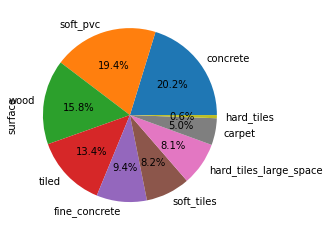

In [5]:
surface_values = robots_surface_df['surface'].value_counts()
print (surface_values)
surface_values.plot.pie(autopct="%.1f%%")


## 1.3

There are no significant correlations, except for the negative correlation between angular_velocity_Y and angular_velocity_z.

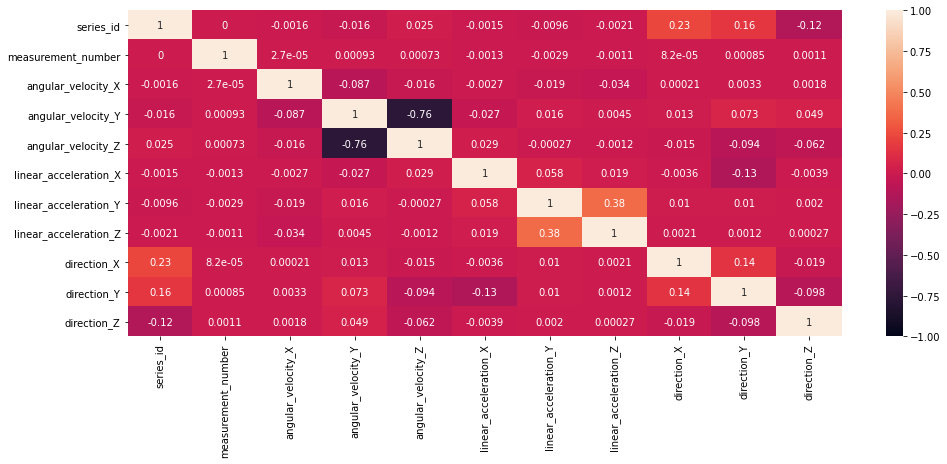

In [6]:
plt.figure(figsize=(16,6))

featuresCorrelationHeatmap = sns.heatmap(robots_movement_df.corr(), annot=True, vmin=-1, vmax=1)

## 1.4
There are some patterns that can be observed, but nothing significant.

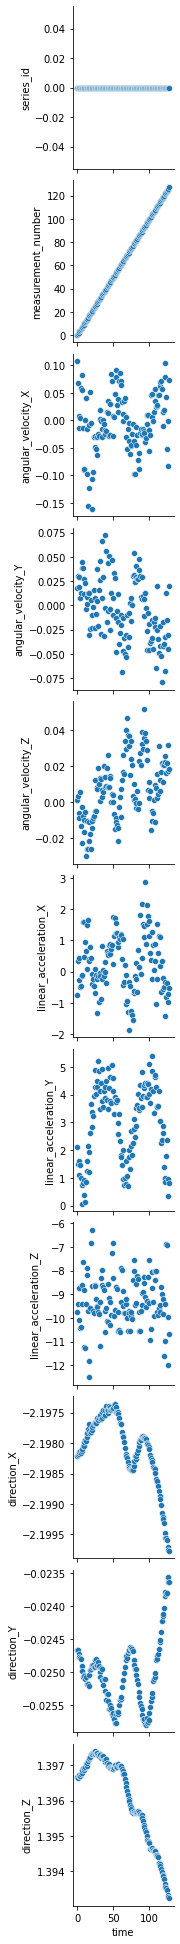

In [7]:
time_plots = robots_movement_df.copy()
indexNames = time_plots[(time_plots['series_id'] != 0)].index
time_plots.drop(indexNames, inplace = True)
time_plots["time"] = np.linspace(0, 127, 128)

sns.pairplot(data=time_plots,
             x_vars =['time'],
             y_vars=time_plots.drop(["time"], axis=1))

# Part 2 - Feature Engineering I and Baseline Models

## 2.1

New shape: 3610 rows × 10 columns

In [8]:
movement_df = robots_movement_df.groupby(by=['series_id']).mean()

## 2.2

In [9]:
x = movement_df.drop(['measurement_number'], axis=1)
x.head()

,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,direction_X,direction_Y,direction_Z
series_id,,,,,,,,,
0,-0.002481,-0.003306,0.007532,0.263418,2.984195,-9.320391,-2.198082,-0.025037,1.396035
1,0.004605,-0.007757,0.006206,0.121867,2.768193,-9.388899,2.426853,-0.010369,-0.492731
2,0.002646,-0.009232,0.027989,0.149711,2.886745,-9.395783,-2.041776,-0.012195,2.055021
3,0.000624,-0.002804,0.007887,0.201791,2.657922,-9.451164,2.351483,-0.015107,-0.635656
4,0.006969,0.046109,-0.142385,-0.086171,2.981498,-9.349988,2.235396,-0.009793,-0.894147


## 2.3

In [10]:
le = LabelEncoder()
y = np.array(le.fit_transform(robots_surface_df["surface"]))

## 2.4 
This model performs very poorly. The reason for this is probably the imbalance in data because most of the points are classifed as concrete, soft pvc or wood and those are the types that appear most often in the dataset. 


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.3)

lr_model = LogisticRegression(max_iter=500)
lr_model.fit(x_train, y_train)
y_predict = lr_model.predict(x_test)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy:  0.29362880886426596


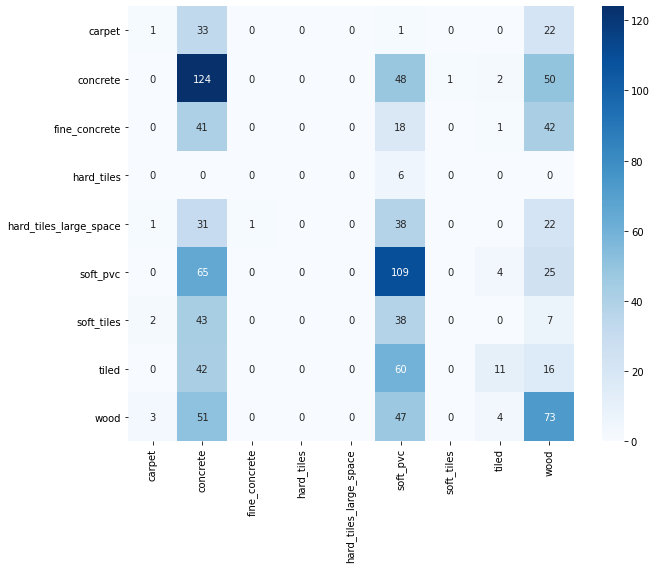

In [12]:
from sklearn import metrics 
cf_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_predict)
categories = le.classes_.tolist()
plt.figure(figsize=(10,8))
ax = sns.heatmap(cf_matrix,
                 annot=True,
                 fmt='g',
                 cmap='Blues',
                 xticklabels=categories,
                 yticklabels=categories)
print("Accuracy: ", metrics.accuracy_score(y_test, y_predict))

## 2.5 
This model behaves better than Logistic regression, but still isn't very accurate. 

In [13]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(x_train, y_train)

y_predict_knn = knn.predict(x_test)

# score on the training data
print(knn.score(x_train, y_train))



0.8246933122279383


0.6112650046168052


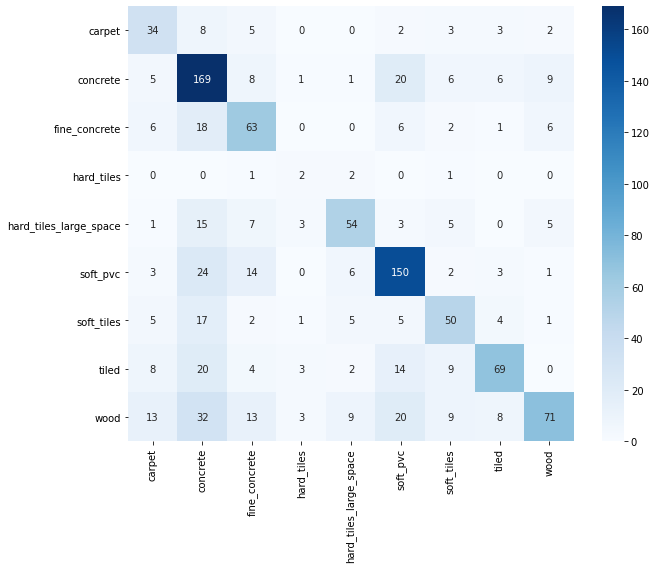

In [14]:
# plot the matrix and accuracy
cf_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_predict_knn)
categories = le.classes_.tolist()
plt.figure(figsize=(10,8))
ax = sns.heatmap(cf_matrix,
                 annot=True,
                 fmt='g',
                 cmap='Blues',
                 xticklabels=categories,
                 yticklabels=categories)

print(metrics.accuracy_score(y_test, y_predict_knn))

## 2.6

This does improve the model, but not significantly. 

In [15]:
from sklearn.model_selection import GridSearchCV
i = 3
n_list = []
while i < 30:
  n_list.append(i)
  i = i + 2

grid_params = {
    "n_neighbors": n_list,
    "metric": ["euclidean", "manhattan", "minkowski"]
}

gs_knn = GridSearchCV(KNeighborsClassifier(),
                      grid_params)

gs_knn_results = gs_knn.fit(x_train, y_train)

print("Best score is: " + str(gs_knn_results.best_score_))
print("Best estimator is: " + str(gs_knn_results.best_estimator_))
print("Best k is: " + str(gs_knn_results.best_params_))

Best score is: 0.6557257464876922
Best estimator is: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
Best k is: {'metric': 'manhattan', 'n_neighbors': 3}


## 2.7
This model performs decently, but still not ideally.  

In [16]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500)
rf.fit(x_train, y_train)

print(rf.score(x_train, y_train))

y_pred_rf = rf.predict(x_test)
print(metrics.r2_score(y_test, y_pred_rf))

1.0
0.32899628252788116


0.791320406278855


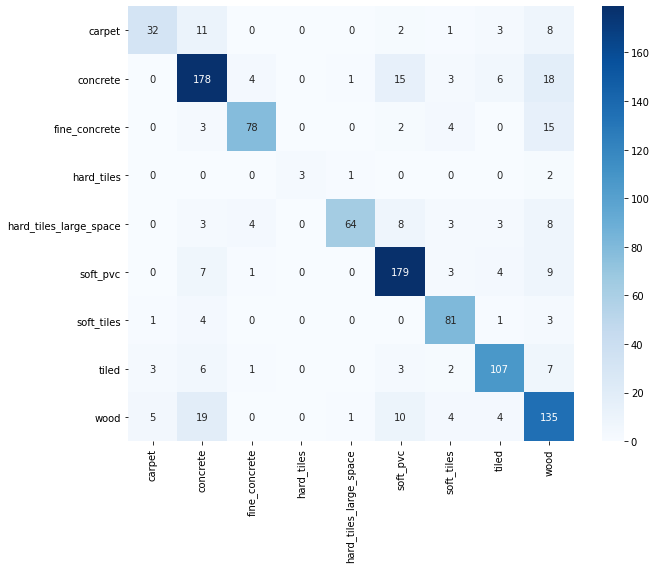

In [17]:
cf_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_rf)
categories = le.classes_.tolist()
plt.figure(figsize=(10,8))
ax = sns.heatmap(cf_matrix,
                 annot=True,
                 fmt='g',
                 cmap='Blues',
                 xticklabels=categories,
                 yticklabels=categories)

print(metrics.accuracy_score(y_test, y_pred_rf))

# Part 3 


## 3.1

We can think of each column as a vector component. For example, direction x can be seen as a c component of a direction vector. This is just the magnitude of each of the vectors in space. 

In [18]:
# add direction total column
movement_df["direction_total"] = np.sqrt(movement_df["direction_X"]**2 + 
                                         movement_df["direction_Y"]**2 +
                                         movement_df["direction_Z"]**2)

movement_df.head()


,measurement_number,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,direction_X,direction_Y,direction_Z,direction_total
series_id,,,,,,,,,,,
0,63.5,-0.002481,-0.003306,0.007532,0.263418,2.984195,-9.320391,-2.198082,-0.025037,1.396035,2.604056
1,63.5,0.004605,-0.007757,0.006206,0.121867,2.768193,-9.388899,2.426853,-0.010369,-0.492731,2.476390
2,63.5,0.002646,-0.009232,0.027989,0.149711,2.886745,-9.395783,-2.041776,-0.012195,2.055021,2.896914
3,63.5,0.000624,-0.002804,0.007887,0.201791,2.657922,-9.451164,2.351483,-0.015107,-0.635656,2.435930
4,63.5,0.006969,0.046109,-0.142385,-0.086171,2.981498,-9.349988,2.235396,-0.009793,-0.894147,2.407611


In [19]:
# add angular velocity column
movement_df["angular_velocity_total"] = np.sqrt(movement_df["angular_velocity_X"]**2 +
                                                movement_df["angular_velocity_Y"]**2 +
                                                movement_df["angular_velocity_Z"]**2)
movement_df.head()
                                                

,measurement_number,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,direction_X,direction_Y,direction_Z,direction_total,angular_velocity_total
series_id,,,,,,,,,,,,
0,63.5,-0.002481,-0.003306,0.007532,0.263418,2.984195,-9.320391,-2.198082,-0.025037,1.396035,2.604056,0.008591
1,63.5,0.004605,-0.007757,0.006206,0.121867,2.768193,-9.388899,2.426853,-0.010369,-0.492731,2.476390,0.010949
2,63.5,0.002646,-0.009232,0.027989,0.149711,2.886745,-9.395783,-2.041776,-0.012195,2.055021,2.896914,0.029591
3,63.5,0.000624,-0.002804,0.007887,0.201791,2.657922,-9.451164,2.351483,-0.015107,-0.635656,2.435930,0.008394
4,63.5,0.006969,0.046109,-0.142385,-0.086171,2.981498,-9.349988,2.235396,-0.009793,-0.894147,2.407611,0.149827


In [20]:
# add linear acceleration column
movement_df["linear_acceleration_total"] = np.sqrt(movement_df["linear_acceleration_X"]**2 +
                                                   movement_df["linear_acceleration_Y"]**2 +
                                                   movement_df["linear_acceleration_Z"]**2)

movement_df.head()
                     

,measurement_number,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,direction_X,direction_Y,direction_Z,direction_total,angular_velocity_total,linear_acceleration_total
series_id,,,,,,,,,,,,,
0,63.5,-0.002481,-0.003306,0.007532,0.263418,2.984195,-9.320391,-2.198082,-0.025037,1.396035,2.604056,0.008591,9.790020
1,63.5,0.004605,-0.007757,0.006206,0.121867,2.768193,-9.388899,2.426853,-0.010369,-0.492731,2.476390,0.010949,9.789238
2,63.5,0.002646,-0.009232,0.027989,0.149711,2.886745,-9.395783,-2.041776,-0.012195,2.055021,2.896914,0.029591,9.830384
3,63.5,0.000624,-0.002804,0.007887,0.201791,2.657922,-9.451164,2.351483,-0.015107,-0.635656,2.435930,0.008394,9.819866
4,63.5,0.006969,0.046109,-0.142385,-0.086171,2.981498,-9.349988,2.235396,-0.009793,-0.894147,2.407611,0.149827,9.814226


## 3.2

In [21]:
new_movement_df = pd.DataFrame()

In [22]:
for col in robots_movement_df.columns:
  new_movement_df[col+'_mean']=robots_movement_df.groupby(['series_id'])[col].mean()
  new_movement_df[col+'_min']=robots_movement_df.groupby(['series_id'])[col].min()
  new_movement_df[col+'_max']=robots_movement_df.groupby(['series_id'])[col].max()
  new_movement_df[col+'_std_dev']=robots_movement_df.groupby(['series_id'])[col].std()

new_movement_df

,series_id_mean,series_id_min,series_id_max,series_id_std_dev,measurement_number_mean,measurement_number_min,measurement_number_max,measurement_number_std_dev,angular_velocity_X_mean,angular_velocity_X_min,angular_velocity_X_max,angular_velocity_X_std_dev,angular_velocity_Y_mean,angular_velocity_Y_min,angular_velocity_Y_max,angular_velocity_Y_std_dev,angular_velocity_Z_mean,angular_velocity_Z_min,angular_velocity_Z_max,angular_velocity_Z_std_dev,linear_acceleration_X_mean,linear_acceleration_X_min,linear_acceleration_X_max,linear_acceleration_X_std_dev,linear_acceleration_Y_mean,linear_acceleration_Y_min,linear_acceleration_Y_max,linear_acceleration_Y_std_dev,linear_acceleration_Z_mean,linear_acceleration_Z_min,linear_acceleration_Z_max,linear_acceleration_Z_std_dev,direction_X_mean,direction_X_min,direction_X_max,direction_X_std_dev,direction_Y_mean,direction_Y_min,direction_Y_max,direction_Y_std_dev,direction_Z_mean,direction_Z_min,direction_Z_max,direction_Z_std_dev
series_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0.0,63.5,0,127,37.094474,-0.002481,-0.160410,0.107650,0.052800,-0.003306,-0.079404,0.072698,0.031544,0.007532,-0.030181,0.051720,0.017127,0.263418,-1.864400,2.85380,0.911175,2.984195,0.075417,5.3864,1.387790,-9.320391,-12.5120,-6.2681,1.095040,-2.198082,-2.199772,-2.197350,0.000574,-0.025037,-0.025795,-0.023562,0.000503,1.396035,1.393233,1.397402,0.001221
1,1,1,1,0.0,63.5,0,127,37.094474,0.004605,-0.254800,0.283420,0.092309,-0.007757,-0.134330,0.112080,0.046523,0.006206,-0.121610,0.129150,0.067533,0.121867,-3.193400,5.10020,1.105945,2.768193,-2.149200,6.6850,1.864457,-9.388899,-16.9280,-2.7449,2.123065,2.426853,2.424739,2.429841,0.001387,-0.010369,-0.012073,-0.009109,0.000822,-0.492731,-0.494641,-0.490164,0.001131
2,2,2,2,0.0,63.5,0,127,37.094474,0.002646,-0.152710,0.141920,0.060168,-0.009232,-0.107810,0.091946,0.035530,0.027989,-0.015697,0.088730,0.021866,0.149711,-2.593000,1.85330,0.756138,2.886745,-1.254000,6.2105,1.769792,-9.395783,-12.4990,-5.7442,1.140267,-2.041776,-2.042950,-2.040610,0.000668,-0.012195,-0.012734,-0.011795,0.000173,2.055021,2.049684,2.061288,0.003219
3,3,3,3,0.0,63.5,0,127,37.094474,0.000624,-0.401520,0.519130,0.179544,-0.002804,-0.168150,0.135780,0.046700,0.007887,-0.073414,0.085345,0.032265,0.201791,-3.793400,4.20320,1.472019,2.657922,-5.825100,11.7430,4.201410,-9.451164,-19.8450,-0.5591,3.478530,2.351483,2.348148,2.356419,0.002101,-0.015107,-0.015698,-0.014645,0.000234,-0.635656,-0.638340,-0.634294,0.000931
4,4,4,4,0.0,63.5,0,127,37.094474,0.006969,-0.104070,0.080904,0.044773,0.046109,0.008231,0.083764,0.016114,-0.142385,-0.213940,-0.063372,0.038489,-0.086171,-1.269600,0.82891,0.437707,2.981498,0.342070,4.8181,1.137776,-9.349988,-10.9750,-7.4490,0.812585,2.235396,2.227161,2.245355,0.005080,-0.009793,-0.010192,-0.009358,0.000241,-0.894147,-0.915040,-0.867983,0.013836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3605,3605,3605,3605,0.0,63.5,0,127,37.094474,-0.003795,-0.704460,0.650330,0.204597,0.033076,-0.288120,0.221860,0.084171,-0.107520,-0.236260,0.072899,0.065031,0.227388,-11.670000,12.74200,3.550899,2.789481,-7.240300,11.7190,2.681216,-9.580662,-37.2730,3.1548,5.458292,1.981312,1.979780,1.982653,0.000667,-0.014402,-0.016808,-0.012843,0.000992,-2.457882,-2.474120,-2.438998,0.010796
3606,3606,3606,3606,0.0,63.5,0,127,37.094474,-0.001424,-0.352810,0.291120,0.141201,-0.014904,-0.179100,0.247770,0.071234,0.075811,-0.028434,0.174710,0.036466,0.135442,-5.640800,4.98990,1.673014,2.891780,-4.090300,10.1170,3.428898,-9.508537,-17.1180,-2.2747,3.244430,-2.120928,-2.124000,-2.117368,0.002013,-0.010691,-0.012164,-0.008644,0.000996,1.662319,1.649609,1.674206,0.007508
3607,3607,3607,3607,0.0,63.5,0,127,37.094474,0.005469,-0.110600,0.132600,0.051259,-0.002753,-0.047831,0.072402,0.023179,0.029943,-0.028317,0.086310,0.024892,0.183429,-1.055500,1.74690,0.6196


Feature engineering affected the performance for every model. All the models work with a higher accuracy on the test data than the previous ones. Unfortunately, only Random Forrest classifer seems accurate enough for it to be used as a model for classification.

In [23]:

x2 = new_movement_df.drop(['measurement_number_mean',
                           'measurement_number_max',	
                           'measurement_number_min', 
                           'series_id_mean',
                           'series_id_max',
                           'series_id_min'], axis=1)

le2 = LabelEncoder()
y2 = np.array(le2.fit_transform(robots_surface_df["surface"]))
x_train2,x_test2,y_train2,y_test2 = train_test_split(x2,y2, test_size=0.3)

lr_model = LogisticRegression(max_iter=500)
lr_model.fit(x_train2, y_train2)
y_predict_lr = lr_model.predict(x_test2)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy:  0.44967682363804246


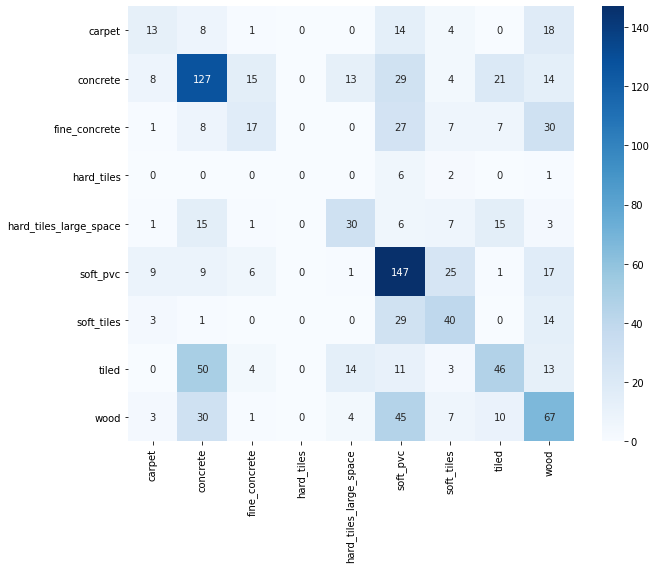

In [24]:
from sklearn import metrics 
cf_matrix = metrics.confusion_matrix(y_true=y_test2, y_pred=y_predict_lr)
categories = le.classes_.tolist()
plt.figure(figsize=(10,8))
ax = sns.heatmap(cf_matrix,
                 annot=True,
                 fmt='g',
                 cmap='Blues',
                 xticklabels=categories,
                 yticklabels=categories)
print("Accuracy: ", metrics.accuracy_score(y_test2, y_predict_lr))

In [25]:
from sklearn.neighbors import KNeighborsClassifier
knn2 = KNeighborsClassifier(n_neighbors=2)
knn2.fit(x_train2, y_train2)

y_predict_knn2 = knn2.predict(x_test2)

# score on the training data
print(knn2.score(x_train2, y_train2))

0.8294420261179264


Accuracy:  0.6629732225300092


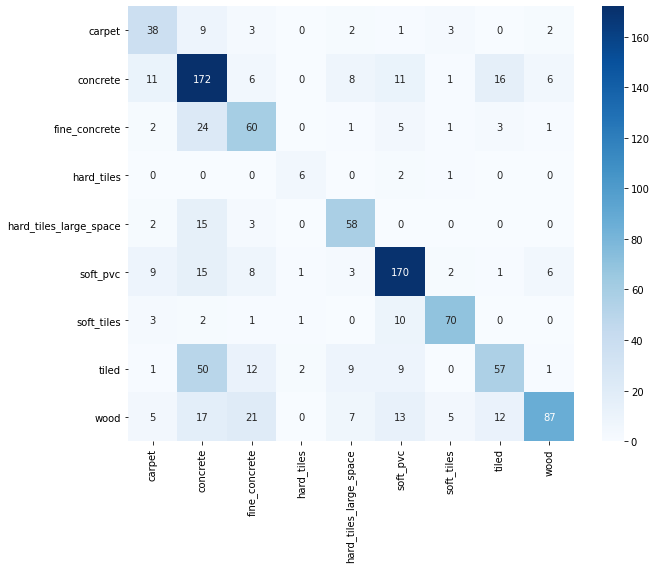

In [26]:
from sklearn import metrics 
cf_matrix = metrics.confusion_matrix(y_true=y_test2, y_pred=y_predict_knn2)
categories = le.classes_.tolist()
plt.figure(figsize=(10,8))
ax = sns.heatmap(cf_matrix,
                 annot=True,
                 fmt='g',
                 cmap='Blues',
                 xticklabels=categories,
                 yticklabels=categories)
print("Accuracy: ", metrics.accuracy_score(y_test2, y_predict_knn2))

In [27]:
from sklearn.ensemble import RandomForestClassifier
rf2 = RandomForestClassifier(n_estimators=500)
rf2.fit(x_train2, y_train2)

print(rf2.score(x_train2, y_train2))

y_pred_rf2 = rf2.predict(x_test2)
print(metrics.r2_score(y_test2, y_pred_rf2))

1.0
0.6520218092378851


0.8624192059095106


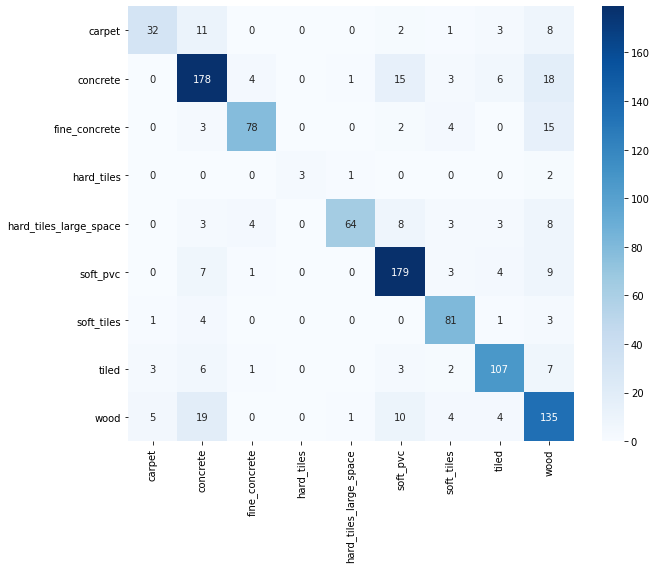

In [28]:
cf_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_rf)
categories = le.classes_.tolist()
plt.figure(figsize=(10,8))
ax = sns.heatmap(cf_matrix,
                 annot=True,
                 fmt='g',
                 cmap='Blues',
                 xticklabels=categories,
                 yticklabels=categories)

print(metrics.accuracy_score(y_test2, y_pred_rf2))